# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Free-energy-profile-for-RNA-duplex-formation" data-toc-modified-id="Free-energy-profile-for-RNA-duplex-formation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Free energy profile for RNA duplex formation</a></div><div class="lev1 toc-item"><a href="#Prepare-calculation" data-toc-modified-id="Prepare-calculation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare calculation</a></div><div class="lev2 toc-item"><a href="#Transition-counts" data-toc-modified-id="Transition-counts-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Transition counts</a></div><div class="lev2 toc-item"><a href="#Load-bias-potentials" data-toc-modified-id="Load-bias-potentials-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load bias potentials</a></div><div class="lev1 toc-item"><a href="#Solve-DHAMed-equations" data-toc-modified-id="Solve-DHAMed-equations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solve DHAMed equations</a></div><div class="lev2 toc-item"><a href="#Use-all-data-points" data-toc-modified-id="Use-all-data-points-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Use all data points</a></div><div class="lev2 toc-item"><a href="#Block-average" data-toc-modified-id="Block-average-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Block average</a></div><div class="lev2 toc-item"><a href="#Vary-observation-interval" data-toc-modified-id="Vary-observation-interval-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Vary observation interval</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydhamed import count_matrix
from pydhamed import run_dhamed

# Free energy profile for RNA duplex formation

We have run coarse-grained simulations of RNA duplex formation with the oxRNA model (https://dna.physics.ox.ac.uk/index.php/RNA_model_introduction). 

# Prepare calculation

## Transition counts

Load trajectory data. Each time point needs to be assigned to a structural/conformational state. I use the number of native base-pairs to assign structural states for the coarse grained RNA. Second but lust column contains the state assignment. The state assigned trajectory is used to determine the transition counts, which serve as input for DHAMed.

In [15]:
traj = np.load("us_step-e4.npy")[:,-2]

In [16]:
traj

array([ 8.,  7.,  8., ...,  0.,  0.,  0.])

In [17]:
c_l = [count_matrix(traj,n_states=9)]

In [18]:
traj.__len__()

200001

## Load bias potentials

Bias potentials were used to sample unfavorable structures. For each structural state and for each window (or simulation run) we need to specify the bias that was acting on the simulations system. 

In [19]:
v_ar = np.genfromtxt("wfile.txt")[:,1].reshape((9,1))

In [20]:
v_ar.shape

(9, 1)



For the simulation of RNA duplex formation we have nine structural states and the simulation was run all at once (in a single simulation run or window). The bias array thus has the shape 9x1.

# Solve DHAMed equations

Solve DHAMed equations for Umbrella Sampling simulations of coarse grained RNA duplex formation. I take the negative log of the bias array to convert the bias into units of $k_BT$.

## Use all data points

In [21]:
og = run_dhamed(c_l, -np.log(v_ar))

36
loglike-start 307329.010043
307329.010043
         Current function value: 288165.228180
         Iterations: 21
         Function evaluations: 52
         Gradient evaluations: 40
time elapsed 0.034942150116 s


## Block average

Estimate uncertainty in the DHAMed free energy profile by splitting the data into five blocks.

In [22]:
n_blocks = 5
bl_l = []
for bl in np.split(traj[1:],n_blocks):
    c_l = [count_matrix(bl,n_states=9)]
    bl_g = run_dhamed(c_l, -np.log(v_ar))
    bl_l.append(np.exp(-bl_g) / np.sum(np.exp(-bl_g)))

32
loglike-start 59535.0856402
59535.0856402
Optimization terminated successfully.
         Current function value: 55154.290427
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
time elapsed 0.0137038230896 s
32
loglike-start 54945.0688078
54945.0688078
Optimization terminated successfully.
         Current function value: 50890.763573
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
time elapsed 0.0107760429382 s
33
loglike-start 30329.4839929
30329.4839929
Optimization terminated successfully.
         Current function value: 27634.820755
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
time elapsed 0.0108389854431 s
34
loglike-start 52453.6162341
52453.6162341
Optimization terminated successfully.
         Current function value: 48500.807605
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
time elapsed 0.01073479

In [23]:
bl_ar = np.column_stack((bl_l))
bl_ln_ar = np.log(bl_ar)

# minmum and maximum values of the PMF (from the five reconstructions) to indicate the uncertainty.
min_pmf = np.min( bl_ln_ar - bl_ln_ar[-1], axis=1)
max_pmf = np.max( bl_ln_ar - bl_ln_ar[-1], axis=1)

In [24]:
bl_ar.shape

(9, 5)

In [25]:
dh_log_err = np.std(-np.log(bl_ar), axis=1) / np.sqrt(n_blocks-1)
dh_log_err.shape

(9,)

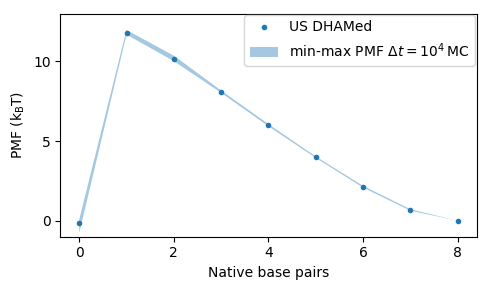

In [26]:
fig, ax = plt.subplots(figsize=(5,3))

# error bar is barely visible
#plt.errorbar(rc, rna_pmf, yerr=dh_log_err, fmt=".", capthick=1,capsize=4
rc = np.arange(0,9)
rna_pmf = og*-1
rna_pmf -= rna_pmf[-1]
plt.plot(rc, rna_pmf, ".", label="US DHAMed")

plt.fill_between(rc, min_pmf, max_pmf, alpha=0.4, label=r"min-max PMF $\Delta t=10^4 \, \mathrm{MC}$ ")

ax.set_xlabel("Native base pairs")
ax.set_ylabel("PMF ($\mathrm{k_BT}$)")
ax.set_ylim(-1,13)
ax.set_xlim(-0.4,8.4)
ax.set_yticks([0,5,10])
ax.set_xticks([0,2,4,6,8])
ax.tick_params(direction='out')

plt.legend(borderaxespad=0.1)
plt.tight_layout()
plt.savefig("rna_pmf.pdf")

The figure reproduces the free energy profile presented in Figure 7B of the manuscript [1].

## Vary observation interval

Here I vary the observation interval. Using a sliding window to determine transition counts I can analyze trajectories even at long observation intervals.

In [27]:
c_l_lag_e7 = [count_matrix(traj,n_states=9, lag=5000)] # 10^4 * 5000  -> 5x10^7

In [28]:
og_e7 = run_dhamed(c_l_lag_e7, -np.log(v_ar))

36
loglike-start 1134671.76583
1134671.76583
         Current function value: 1072622.665740
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 51
time elapsed 0.0457861423492 s


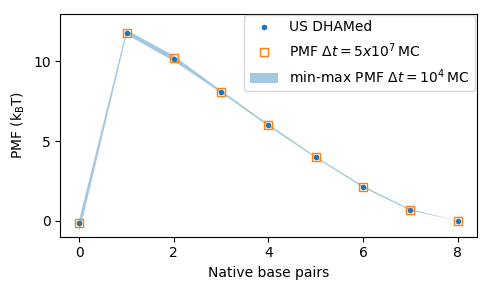

In [29]:
fig, ax = plt.subplots(figsize=(5,3))

# error bar is barely visible
#plt.errorbar(rc, rna_pmf, yerr=dh_log_err, fmt=".", capthick=1,capsize=4
rc = np.arange(0,9)
rna_pmf = og*-1
rna_pmf -= rna_pmf[-1]
plt.plot(rc, rna_pmf, ".", label="US DHAMed")
rna_pmf_obs_e7 = og_e7*-1
rna_pmf_obs_e7 -= rna_pmf_obs_e7[-1]
plt.plot(rc, rna_pmf_obs_e7, "s", mew=1, mfc="None",
        label="PMF $\Delta t=5x10^7 \, \mathrm{MC}$ ")

plt.fill_between(rc, min_pmf, max_pmf, alpha=0.4, label=r"min-max PMF $\Delta t=10^4 \, \mathrm{MC}$ ")

ax.set_xlabel("Native base pairs")
ax.set_ylabel("PMF ($\mathrm{k_BT}$)")
ax.set_ylim(-1,13)
ax.set_xlim(-0.4,8.4)
ax.set_yticks([0,5,10])
ax.set_xticks([0,2,4,6,8])
ax.tick_params(direction='out')

plt.legend(borderaxespad=0.1)
plt.tight_layout()

# References

[1] Dynamic Histogram Analysis To Determine Free Energies and Rates from biased 
Simulations, L. S. Stelzl, A. Kells, E. Rosta, G. Hummer, J. Chem. Theory Comput.,
2017, http://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00373